<a href="https://colab.research.google.com/github/elizagb/Vegetation-Change-Analysis/blob/main/VegetationChangeAnalysis_EarthEngine_Sentinel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Change and Wildfire: Satellite Image Analysis with Earth Engine and Python Open Source Packages

This exercise looks at forest cover change in a region of the McKenzie River basin, Oregon, that burned in the Holiday Farm Fire of 2020. More information about this fire can be found here:

 * https://www.fs.usda.gov/detailfull/willamette/fire/?cid=fseprd835646

introduces Google Earth Engine and raster satellite image analysis and visualization. Working with data from the Sentinel-2 satellite system:
* Assemble images around a specific location and within a specified time period
 * Query metadata information about the images
* View an image statically and with an interactive map
* Calculate a 'spectral indice'
* Calculate change between two images
* Classify an image into statistical clusters
* Create a time series dataset from single location from the images
 * Visualize the time series with an interactive map

The exercise can be run without any knowledge of coding, but for some background, you might want to run through the following coloboratory notebooks:

1. Earth Engine Python API Colab Setup
https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb

2. Google Earth Engine with Python - Developer's Guide
https://colab.research.google.com/github/csaybar/EEwPython/blob/dev/1_Introduction.ipynb#scrollTo=5AkUqloUQpXv



## Set up the analysis environment

The basic steps to get things set up, using 'python' scripting jargon, are:

1.   Install packages
2.   Import modules
3. 'Authenticate' earth engine
4. Define functions

Colaboratory comes with a variety of standard scientific computing 'libraries', and many others can be installed fairly easily.  This exercise will use the 'earth engine api', the 'geemap' library for visualizing earth engine data, and a variety of libraries to plot results.

- ## *You may now have to `RESTART RUNTIME` (with a button in the output above) to properly import the modules in the next step*

### Import modules

Plotting, visualization, and data analysis tools

In [ ]:
# earth engine and statistical analysis
from IPython.display import Image
import ee, datetime
import geemap.core as geemap
import pandas as pd
from pylab import *
import seaborn as sns

# file management
import os
import glob

# geospatial and plotting modules
# import geopandas as gpd

import geemap.foliumap as geemap
import folium
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt


 - if you get an error about '_tornado...' then try restarting the runtime in the cel above.

### Authenticate earth engine

Since earth engine requires a login, to use it with colaboratory requires 'authenticating' an analysis session. That is, giving permission via a google account. Running the cell below will provide a link to a google authentication website, which will ask your permission and then provide a verification code to paste into a box - then hit enter to finish the process.

*Sometimes there are issues authenticating* - see: https://github.com/googlecolab/colabtools/issues/4228

If you have problems on the next step (initializing the access to earth engine) you may need to specifically name the project space to work in - this can be identified by visiting your Google Console at:

https://console.cloud.google.com/apis/dashboard

If there is a specific project name you need to put in, the console should automatically put you in that project space (if you are logged into your google account). The name of the project should be in the url shown, such as:

`https://console.cloud.google.com/apis/dashboard?project=cartospy`

for me when I enable access.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

Once it has `Successfully saved authorization token` the session can be 'initialized' - you may need to provide a 'project' name, which can be your earth engine user name shown on https://code.earthengine.google.com/ on the top right when you are logged in.

## Modify the project name below to match your own earth engine / google account name

In [ ]:
# start up the session
ee.Initialize(project='ee-npkohler')

# Area overview

This example looks at the short-term impacts of the Holiday Farm fire of Sep-Oct, 2021 in the Lane County, Oregon.  

## Define Some Analysis Functions



*   **Mask Clouds**
*  **Define indices**


Functions do something with information. Here are functions to *mask* out clouds and cloud shadows, and to calculate a variety of *spectral indices* from the image data.   Sentinel-2 and Landsat 8 satellite image data are used.

- Landsat 8 data is called with `ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")` in the script and described here: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR

https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2


- The functions for masking are adapted from here: https://code.earthengine.google.com/?scriptPath=Examples:Datasets/LANDSAT_LC08_C01_T1_SR

- Sentinel-2 data is called with `ee.ImageCollection("COPERNICUS/S2_SR")` and described here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED

**Sentinel-2** image bands used in the functions are:

- Band 4 = red
- Band 8 = NIR
- at 10m pixel resolution

**Landsat 8** bands used are:
- Band 4 = red
- Band 5 = NIR
- at 30m pixel resolution

The exercise uses Sentinel-2 data, and can be adapted to work with Landsat 8.

https://developers.google.com/earth-engine/landsat_c1_to_c2

### Cloudmask functions

These will mask clouds from the image collections to help improve analysis results of the time series data. These take advantage of the additional 'quality' layers which give some estimate on a pixel-by-pixel basis of the cloudiness of an image.

## Why is cloudmasking important?



In [ ]:
#function to use QA band to filter clouds
#Landsat 8 sr data
def maskL8sr(image):
  #Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = image.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd((cloudShadowBitMask).eq(0)).bitwiseAnd((cloudsBitMask).eq(0))
  return image.updateMask(mask)

In [ ]:
def mask8srC2(image):
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
  return image.updateMask(qa_mask)

In [ ]:
#function to use QA band to filter clouds
#Sentinel 2 data
def maskS2clouds(image):
  qa = image.select('QA60')

  #Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  #Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cirrusBitMask).eq(0)
  mask3 = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cirrusBitMask).eq(0)
  #cloud_img = image.updateMask(mask)
  #cir_img = cloud_img.updateMask(mask2)

  return image.updateMask(mask).updateMask(mask2)
  #return image.updateMask(mask)

### Function to scale the data

In [ ]:
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_band = image.select('ST_B6').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_band, None, True
  )



### Spectral indices and transformations

Spectral indices are designed to combine different wavelengths of energy in order to highlight some materials or features of interest.

Code for the Landsat 8 indices was adapted from *renelikestacos* on github. There are quite a few here, and many more have been created.

This exercise uses the *NDVI (Normalized Difference Vegetation Index)* as an example. NDVI is [described here](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php) in the context of the MODIS sensor system - this exercise uses Sentinel-2 imagery which has 10 meter size pixels.

Other indices are described here:
- [Landsat 8 Spectral Indices](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-surface-reflectance-derived-spectral-indices?qt-science_support_page_related_con=0#qt-science_support_page_related_con)
- [Sentinel-2 indices](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/) On first look-over I thought there was one for "Macaroni" but I misread the table.

### Landsat 8 indices

https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio

NBR is used to identify burned areas and provide a measure of burn severity. It is calculated as a ratio between the NIR and SWIR values in traditional fashion.

(NIR - SWIR) / (NIR + SWIR)

In Landsat 4-7, NBR = (Band 4 – Band 7) / (Band 4 + Band 7).

In Landsat 8-9, NBR = (Band 5 – Band 7) / (Band 5 + Band 7).

https://www.geo.fu-berlin.de/en/v/geo-it/gee/2-monitoring-ndvi-nbr/2-2-calculating-indices/nbr-s2/index.html



In [ ]:
# Landsat 8 indices
def NDVI(image):
    return image.normalizedDifference(['B5', 'B4'])

def SAM(image):
    band1 = image.select("B1")
    bandn = image.select("B2","B3","B4","B5","B6","B7","B8","B9");
    maxObjSize = 256;
    b = band1.divide(bandn);
    spectralAngleMap = b.atan();
    spectralAngleMap_sin = spectralAngleMap.sin();
    spectralAngleMap_cos = spectralAngleMap.cos();
    sum_cos = spectralAngleMap_cos.reduce(ee.call("Reducer.sum"));
    sum_sin = spectralAngleMap_sin.reduce(ee.call("Reducer.sum"));
    return ee.Image.cat(sum_sin, sum_cos, spectralAngleMap_sin, spectralAngleMap_cos);

#Enhanced Vegetation Index
def EVI(image):
    # L(Canopy background)
    # C1,C2(Coefficients of aerosol resistance term)
    # GainFactor(Gain or scaling factor)
    gain_factor = ee.Image(2.5);
    coefficient_1 = ee.Image(6);
    coefficient_2 = ee.Image(7.5);
    l = ee.Image(1);
    nir = image.select("B5");
    red = image.select("B4");
    blue = image.select("B2");
    evi = image.expression(
        "Gain_Factor*((NIR-RED)/(NIR+C1*RED-C2*BLUE+L))",
        {
            "Gain_Factor":gain_factor,
            "NIR":nir,
            "RED":red,
            "C1":coefficient_1,
            "C2":coefficient_2,
            "BLUE":blue,
            "L":l
        }
    )
    return evi

#Atmospherically Resistant Vegetation Index
def ARVI(image):
    red = image.select("B4")
    blue = image.select("B2")
    nir = image.select("B5")
    red_square = red.multiply(red)
    arvi = image.expression(
        "NIR - (REDsq - BLUE)/(NIR+(REDsq-BLUE))",{
            "NIR": nir,
            "REDsq": red_square,
            "BLUE": blue
        }
    )
    return arvi

#Leaf Area Index
def LAI(image):
    nir = image.select("B5")
    red = image.select("B4")
    coeff1 = ee.Image(0.0305);
    coeff2 = ee.Image(1.2640);
    lai = image.expression(
        "(((NIR/RED)*COEFF1)+COEFF2)",
        {
            "NIR":nir,
            "RED":red,
            "COEFF1":coeff1,
            "COEFF2":coeff2
        }
    )
    return lai

### Sentinel-2 indices

This exercise demonstrates the use of Sentinel-2 image data, so these indices need to be adapted to the different band names in this dataset. Only the NDVI and NBR are needed for this exercise.

“Sentinel-2 Datasets in Earth Engine.” n.d. Google for Developers. Accessed March 10, 2025. https://developers.google.com/earth-engine/datasets/catalog/sentinel-2.

In [ ]:
# Normalized burn ratio
def senNBR(image):
  return image.normalizedDifference(['B8', 'B12'])

In [ ]:
# adapted to Sentinel-2

# NDVI for Sentinel-2 bands
def senNDVI(image):
    return image.normalizedDifference(['B8', 'B4'])

## Create target areas for analysis

A single point will be used to set the initial data search. If you want to run this analysis for a different area, change the latitude, longitude coordinates below.  

Note that this is 'x, y' style (longitude, latitude)
 - Hagen Research Natural Area (up the South Fork of Gate Creek): [-122.418960, 44.163945]


In [ ]:
# create location of interest
rnapoint = [-122.418960, 44.163945]

# Create earth engine point
point = {'type':'Point', 'coordinates':rnapoint}

## Create image collection

An 'image collection' is a group (or filtered group) of related imagery or other data.

- [ImageCollection Overview](https://samapriya.github.io/gee-py/projects/collection_overview/)

Images in earth engine are described here.

- [Image Overview](https://samapriya.github.io/gee-py/projects/imgoverview/)

Collections can be vast, so commonly they are filtered by a geographic area or time period.

#### Set time period

This exercise uses data from early 2015 to October 10, 2020. The Sentinel-2 image collection frequency increases over this time as a second sensor comes into use.

Landsat 8 dataset availability is from April 2013 onwards, so a longer time period could be analysed with this data.

If you want to run this analysis for a different area, you probably will want to adjust the time period below to slightly before the event being examined and shortly after the event.

In [ ]:
# Set start and end date
startTime = datetime.datetime(2015, 3, 28)
# endTime = datetime.datetime.now()
endTime = datetime.datetime(2020, 11, 9)

### Load Sentinel-2 image collection




In [ ]:
# Create Sentinel-2 image collection
#collection = ee.ImageCollection("COPERNICUS/S2").filterDate(startTime, endTime).filterBounds(point)
# Udated Create Sentinel-2 image collection
collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate(startTime, endTime).filterBounds(point)

# Create Landsat 8 image collection
#L8collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filterDate(startTime, endTime).filterBounds(point)

### Image Collection Information and Metadata

It is usually a good idea to examine the data in the collections created.

In [ ]:
# Get the number of images.
count = collection.size()
print('Count: ', str(count.getInfo())+'\n')

Count:  144



In [ ]:
# Get the date range of images in the collection.
drange = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
mindate = (ee.Date(drange.get('min')).getInfo())
maxdate = (ee.Date(drange.get('max')).getInfo())
print(f'Sentinel 2 Date range: {mindate} to {maxdate}')

Sentinel 2 Date range: {'type': 'Date', 'value': 1530990745611} to {'type': 'Date', 'value': 1604862746318}


Those dates look a little odd - they are a timestamp (in milliseconds) from Jan 1, 1970 - this is 'UNIX epoch time.' We can convert back to a more human-readable format this way:

In [ ]:
# divide by 1000 to convert from milliseconds
datetime.datetime.fromtimestamp(0/1000)

datetime.datetime(1970, 1, 1, 0, 0)

So the date / time of the oldest image in this particular collection is:

In [ ]:
datetime.datetime.fromtimestamp(mindate['value']/1000)

datetime.datetime(2018, 7, 7, 19, 12, 25, 611000)

There are many other types of information about the images in the metadata. Take a look at a list of them.

In [ ]:
import pprint

In [ ]:
#Get a list of all metadata properties.
properties = collection.propertyNames()
pprint.pprint('Metadata properties: '+str(properties.getInfo())) # ee.List of metadata properties

("Metadata properties: ['date_range', 'period', 'system:visualization_0_min', "
 "'type_name', 'keywords', 'system:visualization_0_bands', 'thumb', "
 "'description', 'source_tags', 'system:id', 'visualization_0_max', "
 "'provider_url', 'title', 'sample', 'tags', 'system:visualization_0_max', "
 "'product_tags', 'provider', 'visualization_0_min', 'system:version', "
 "'system:visualization_0_name', 'visualization_0_name', "
 "'visualization_0_bands']")


### Metadata for the first image in the collection

'Metadata' or standarized information about a dataset, is useful both for human-understanding of the usefulness (or not) of a particular dataset and for making workflows between APIs and other software possible.

More information about getting metatdata can be found at these links:
- https://developers.google.com/earth-engine/ic_info
- https://samapriya.github.io/gee-py/projects/collection_meta/

In [ ]:
# sort the collection by time of image acquisition
sorted = collection.sort("system:time_start");

# Get the first (oldest) image.
scene = sorted.first()

In [ ]:
#properties of the image
properties = scene.propertyNames()
pprint.pprint('Metadata properties: '+str(properties.getInfo())) # ee.List of metadata properties

("Metadata properties: ['system:version', 'system:id', 'SPACECRAFT_NAME', "
 "'SATURATED_DEFECTIVE_PIXEL_PERCENTAGE', 'BOA_ADD_OFFSET_B12', "
 "'CLOUD_SHADOW_PERCENTAGE', 'system:footprint', 'SENSOR_QUALITY', "
 "'GENERATION_TIME', 'CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', "
 "'CLOUD_COVERAGE_ASSESSMENT', 'THIN_CIRRUS_PERCENTAGE', 'GRANULE_MEAN_WV', "
 "'BOA_ADD_OFFSET_B1', 'BOA_ADD_OFFSET_B2', 'DATASTRIP_ID', "
 "'BOA_ADD_OFFSET_B5', 'BOA_ADD_OFFSET_B6', 'BOA_ADD_OFFSET_B3', "
 "'BOA_ADD_OFFSET_B4', 'BOA_ADD_OFFSET_B9', 'BOA_ADD_OFFSET_B7', "
 "'BOA_ADD_OFFSET_B8', 'GRANULE_ID', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8', "
 "'DATATAKE_TYPE', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B9', "
 "'MEAN_INCIDENCE_AZIMUTH_ANGLE_B6', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B7', "
 "'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4', 'NOT_VEGETATED_PERCENTAGE', "
 "'MEAN_INCIDENCE_AZIMUTH_ANGLE_B5', 'RADIOMETRIC_QUALITY', "
 "'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2', 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3', "
 "'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1', 'HIGH_PROBA

In [ ]:
#Get the 'tile' location identifier
target = 'MGRS_TILE'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

MGRS_TILE = 10TEP


In [ ]:
#Get the data id
target = 'GRANULE_ID'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

GRANULE_ID = L2A_T10TEP_A015883_20180707T190608


In [ ]:
#Get estimated cloud cover
target = 'CLOUD_COVERAGE_ASSESSMENT'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

CLOUD_COVERAGE_ASSESSMENT = 1.027757


In [ ]:
#Get the timestamp and convert it to a date.
date = ee.Date(scene.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2018-07-07 19:12:25.611000


In [ ]:
# identify the oldest image
oldest = collection.sort('system:time_start').limit(1)
scene = oldest.first()
#Get a specific metadata property.
target = 'system:time_start'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

#Get the timestamp and convert it to a date.
date = ee.Date(scene.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

system:time_start = 1530990745611
2018-07-07 19:12:25.611000


# **Assignment: Geog 486**

## Lab Writeup Question #1:

What  does the “MGRS_TILE” metadata mean in the context of the Sentinel-2 image collection - how do we interpret the value ‘10TEP’? Describe how the Sentinel-2 tile system works.

Here is the code cell again...

In [ ]:
#Get the 'tile' location identifier
target = 'MGRS_TILE'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

MGRS_TILE = 10TEP


## Visualization and Analysis

### View the most recent image

The data can be viewed as a static image or with an interactive map. First, the static image - these are handy because you can copy and paste them directly into another document


In [ ]:
# Limit the collection to the 1 most recent images.
recent = collection.sort('system:time_start', False).limit(1)
# pull the image from the collection
image = recent.first()
print('Recent images: '+str(recent.getInfo())+'\n')

Recent images: {'type': 'ImageCollection', 'bands': [], 'version': 1741647532576091, 'id': 'COPERNICUS/S2_SR_HARMONIZED', 'properties': {'date_range': [1490659200000, 1647907200000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scale

## Date of the most recent image (for this example)

In [ ]:
#Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2020-11-08 19:12:26.318000


In [ ]:
# set the visualization parameters for the output
visParams = {'bands': ['B4', 'B3', 'B2'], 'max': 3000, 'dimensions':1000 }

# create image thumbnail in earth engine and view
thumbnail = image.getThumbUrl(visParams)
Image(url=thumbnail)

It is a bit cloudy as of this run. The 'least cloudy' images - there are probably many, can be pulled from the collection using the Quality Assurance band

### Get the least cloudy image

The metadata for the collection allows the sorting by estimated cloud cover - for now, limit it to the ten least cloudy images


In [ ]:
#sort collection by least cloud cover and take the top 10
sorted = collection.sort('CLOUD_COVERAGE_ASSESSMENT').limit(10)

# Get the first (least cloudy) image.
image = sorted.first();

In [ ]:
# Get the number of images.
count = sorted.size()
print('Count: ', str(count.getInfo())+'\n')

# Get the date range of images in the collection.
drange = sorted.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
print('Sentinel 2 Date range: ', str(ee.Date(drange.get('min')).getInfo()), str(ee.Date(drange.get('max')).getInfo())+'\n')

Count:  10

Sentinel 2 Date range:  {'type': 'Date', 'value': 1566846749124} {'type': 'Date', 'value': 1602270748376}



In [ ]:
#Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2019-08-26 19:12:29.124000


An image from August 26. 2019 using the harmonized Sentinel-2 collection. View this 'least cloudy' image.

In [ ]:
visParams = {'bands': ['B4', 'B3', 'B2'], 'max': 3000, 'dimensions':1000}
thumbnail = image.getThumbUrl(visParams)
Image(url=thumbnail)

### Calculate and view NDVI and NBR

This image is much better.

The NDVI is calculated with a ratio of two wavelenths of reflected energy - 'red' and 'near-infrared'.

Higher NDVI values should correspond to larger amounts of green vegetation. To calculate this, run the Sentinel-2 NDVI function made earlier in the exercise on the existing image.

The 'Normalized Burn Ratio' is calculated by...

In [ ]:
# run the sentinel NDVI function
sndvi = senNDVI(image)
# sentinel normalized burn ratio
snbr = senNBR(image)

### View the NBR image

In [ ]:
nbrParams = {'min': -1, 'max': 1, 'palette': ['red', 'white', 'grey'], 'dimensions':1000};
thumbnail = snbr.getThumbUrl(nbrParams)
Image(url=thumbnail)

### View the NDVI image

In [ ]:
# change visualization setting for the NDVI data
visParams = {'min':0, 'max': 1, 'palette': ['grey', 'yellow', 'green'], 'dimensions':1000}
thumbnail = sndvi.getThumbUrl(visParams)
Image(url=thumbnail)

Brighter green areas in the image should represent areas with higher amounts of growing green vegetation.

This image illustrates how human and natural forces are shaping the landscape, and important for understanding the image

### View scene interactively

To examine whether NDVI is actually showing growing vegetation more closely, an interactive map is useful.  

The *folium* python library can be used to view this same data on an interactive map.  Multiple layers and other graphics can also be viewed, ans the visualization saved as an .html file.

First, lets get the parameters for visualization set up.

In [ ]:
# visualization settings
rgbParams = {'bands': ['B4', 'B3', 'B2'], 'min':0.0, 'max': 3000, 'gamma': [1.4,2.2, 1.4]}
ndviParams = {'min':0, 'max': 1,  'palette': ['grey', 'yellow', 'green']}
nbrParams = {'min': -1, 'max': 1, 'palette': ['red', 'white', 'grey']};

In [ ]:
# flip the point coordinate to be lat, long (y, x) for folium
f = folium.Figure(width=1200, height=600)
Map = geemap.Map(center=rnapoint[::-1], zoom= 12).add_to(f)
Map.addLayer(image, rgbParams, 'Natural Color Sentinel-2');
Map.addLayer(sndvi, ndviParams, 'NDVI')
Map.addLayer(snbr, nbrParams, 'Nbr')
Map.addLayerControl()
#Map
f

## Lab Writeup Question #2: Compare NDVI and NBR

 Compare the NDVI and NBR images for the post-fire date. In what areas of the landscape do they seem most similar and most different? What aspects of topography of land cover seem to influence the diffences?

### Find the least cloudy recent image and examine

Now, to compare the above image (from 2019) with a more recent, relatively cloud free image from the post-fire period

In [ ]:
# Limit the collection to the 10 most recent images.
recent = collection.sort('system:time_start', False).limit(10)
# sort by cloud coverage
sorted = recent.sort('CLOUD_COVERAGE_ASSESSMENT')

# Get the first (least cloudy) image in the sorted collection
recentqa = sorted.first()

#Get the timestamp and convert it to a date.
date = ee.Date(recentqa.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))


# calculate NDVI
recentndvi = senNDVI(recentqa)

# calculate NBR
recent_nbr = senNBR(recentqa)

2020-09-29 19:12:27.773000


#### An image from October 9, 2020

In this run, it is Oct. 9th, 2020.

Lets look at this data, and add the point used to 'filter' the collection geographically as well.

In [ ]:
# flip the point coordinate to be lat, long (y, x) for folium
f = folium.Figure(width=800, height=600)
Map = geemap.Map(center=rnapoint[::-1], zoom= 12).add_to(f)

# add layers
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'After Natural Color')
Map.addLayer(recentndvi, ndviParams, 'NDVI after')
Map.addLayer(sndvi, ndviParams, 'NDVI before')
Map.addLayer(snbr,nbrParams, 'NBR before')
Map.addLayer(recent_nbr,nbrParams, 'NBR after')
Map.addLayerControl()

# add marker point
folium.Marker(rnapoint[::-1], popup='<i>Research Natural Area</i>').add_to(Map)

f

## Use image math (Map Algebra) to compare the images

One simple way to analyse change is with a 'difference image' - we will look at the difference in vegetation greenness between two dates.

#### Compute a difference image of NDVI between the two dates.

Image math is relatively straightforward with earth engine (and it could also be calculated outside earth engine with the 'numpy' and related modules.

In [ ]:
# create image expression
# the 'subtract() mathmatical operator could also be used
# dif = recentndvi.subtract(sndvi)
dif = image.expression('new-old', {'new': recentndvi, 'old': sndvi})
difParams = {'min':-1, 'max': 1, 'palette': ['red', 'grey', 'green']}

Examine the result - redder areas have less green vegation recently compared to 2017, while green areas have more.

In [ ]:
# plot the difference image along with the other layers
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(sndvi, ndviParams, 'NDVI before')
Map.addLayer(dif, difParams, 'dif')
Map.addLayerControl()
folium.Marker(rnapoint[::-1], popup='<i>Research Natural Area</i>').add_to(Map)

f

# Assignment: Geog 486

## Lab Writeup Question #3:

## What explains the changes visible in the NDVI difference image?

Greener areas are estimated to have more growing green vegetation recently, while redder areas are estimated to have less. Think about the time difference between the images as well.

- seasonality,
- atmosphere,
- solar orientation,
- actual LULC change

There is likely more than one factor at play - don't forget to look at the images from the two dates in addition to the NDVI difference image for your answer - and to examine the entire image area using the zoom and pan tools.

For the purposes of examining the impacts of a wildfire after two years since it occurred, what considerations should be taken in selecting the 'after' image?

## Time Series Analysis

Since the collection has hundreds of images of this area since 2015, this data can be used to look at the seasonal and annual variation of NDVI over a single point as a time series.


### Retrieve information over the collection time period

The point used to geographically limit the image collection can be used to gather information from a single area over the entire time period.  The code for this is described [here](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-getregion).  

In this example, the point is the location of a "Research Natural Area"

In [ ]:
info = collection.getRegion(point,10).getInfo()

### mask clouds to create a filtered collection

We can use the cloud mask function created earlier to remove data that has been identified as cloudy in the collection, to compare with the data above.

This new result will be called `dataset`

In [ ]:
# apply the cloud mask to the collection
maskeddata = collection.map(maskS2clouds)

Get information about the filtered collection

In [ ]:
# get the data for a specific area
info_filt = maskeddata.getRegion(point,10).getInfo()

### See the impacts of clouds: Compare the unfilitered and the filtered collection

Plot the data by turning it into a pandas dataframe and using the seaborn package to visualize it

## unfiltered

Text(0.5, 1.0, 'NDVI')

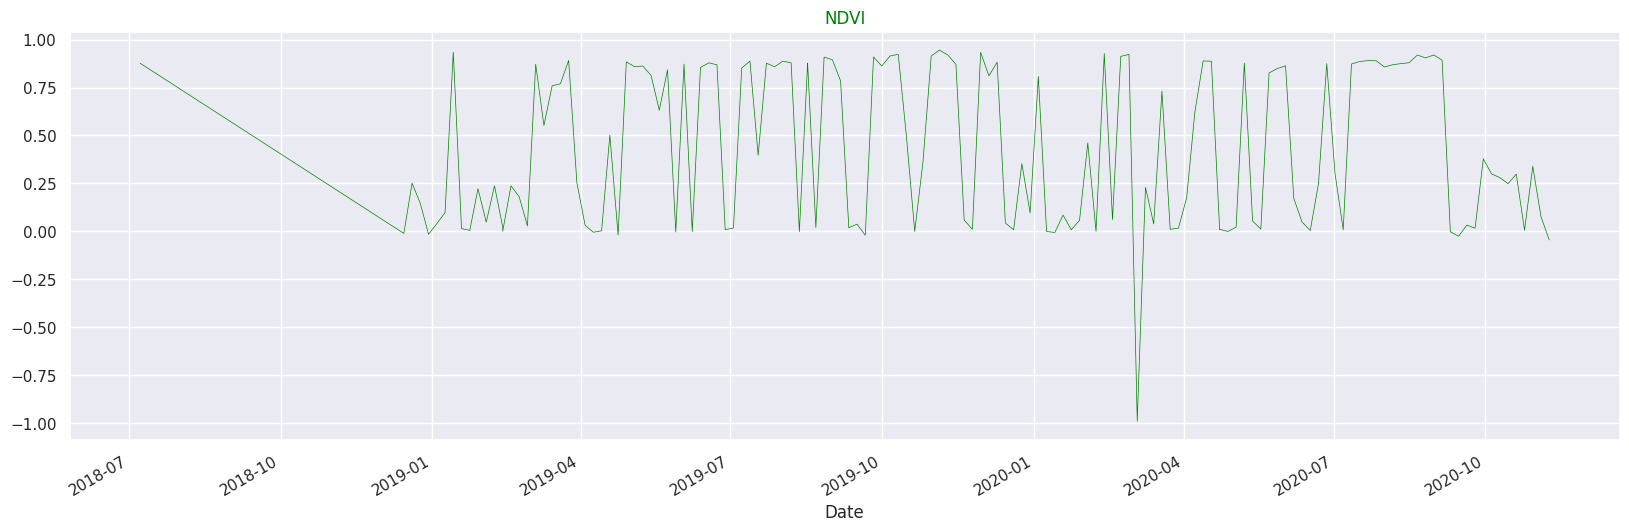

In [ ]:
# plot the ndvi
data = info

# Reshape image collection
header = data[0]
data = array(data[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
#band_list = ['RED',u'NIR']
band_list = ['B4',u'B8']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# reshaoe NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df['NDVI'].plot(linewidth=0.5, color="green")
plt.title('NDVI', color='green')

Lots of spikiness - much of it related to cloudy pixels

### Plot the filtered data

Text(0.5, 1.0, 'NDVI')

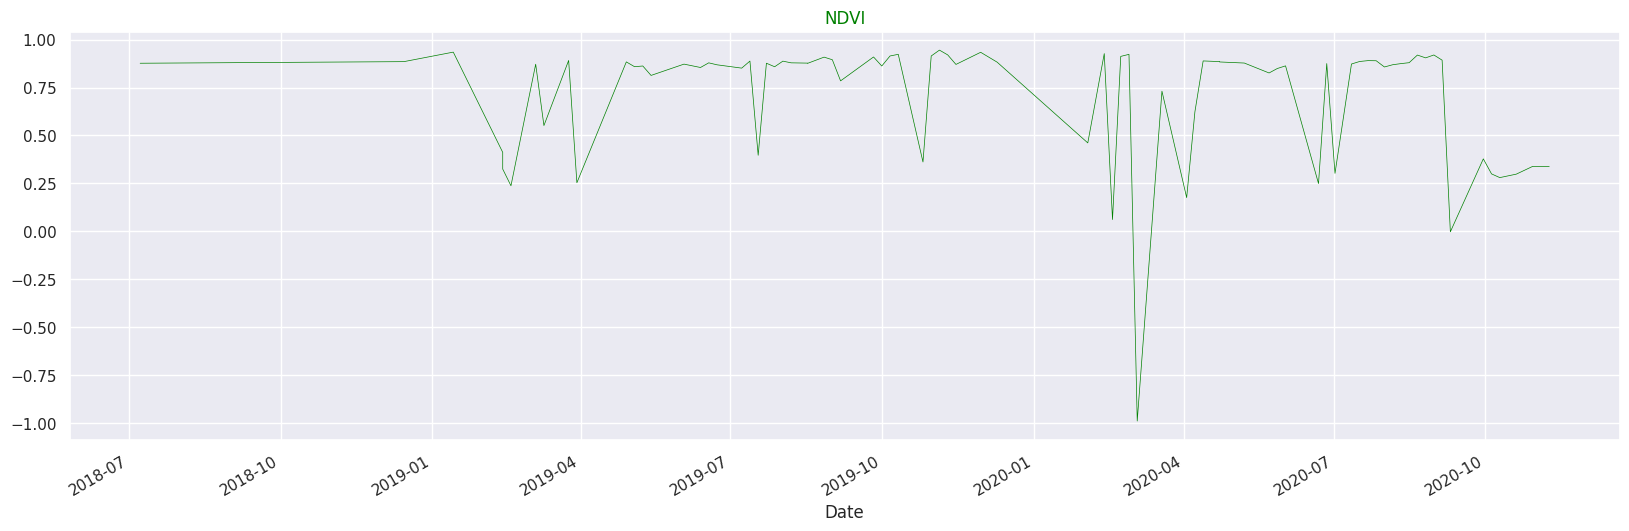

In [ ]:
## plot the ndvi
data = info_filt

# Reshape image collection
header = data[0]
data = array(data[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
#band_list = ['RED',u'NIR']
band_list = ['B4',u'B8']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)
# reshaoe NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df['NDVI'].plot(linewidth=0.5, color="green")
plt.title('NDVI', color='green')

A little better, now examine the actual filtered data

In [ ]:
df.head(5)

,NDVI,Date
Date,,
2018-07-07 19:12:25.611,0.876605,2018-07-07 19:12:25.611
2018-12-14 19:12:16.000,0.884891,2018-12-14 19:12:16.000
2018-12-19 19:12:19.000,0.893177,2018-12-19 19:12:19.000
2018-12-24 19:12:17.000,0.901463,2018-12-24 19:12:17.000
2018-12-29 19:12:21.000,0.909749,2018-12-29 19:12:21.000


## Interactive mapping

### Make an interactive map with the chart data embedded

The information we just plotted can be placed onto the interactive map, using the 'Altair' module for plotting.

Altair is designed to quickly make charts that can be displayed online

https://altair-viz.github.io/getting_started/overview.html

Using the "NDVI" and "Date" columns, plot the NDVI over time.


In [ ]:
chart = alt.Chart(df).mark_line().encode(y='NDVI', x='Date')
chart

alt.Chart(...)

Fix the size a bit.

Chart Size:
https://altair-viz.github.io/user_guide/customization.html#adjusting-chart-size

In [ ]:
chart = alt.Chart(df).mark_line().encode(y='NDVI', x='Date').properties(width=700, height=200)

chart

alt.Chart(...)

This is still pretty spikey.  Much this is probably due to clouds, haze, smoke, or fog in the atmosphere - or snow on the ground.

### Embed the chart onto the folium map

This rendition of the data can be embedded on the map as a pop up for a point.


In [ ]:
chart = alt.Chart(df).mark_line().encode(y='NDVI', x='Date').properties(width=500, height=150)
vis1 = chart.to_json()

f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
#Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
#Map.addLayer(sndvi, ndviParams, 'NDVI before')
Map.addLayer(dif, difParams, 'dif')
Map.addLayerControl()
#folium.Marker(rnapoint[::-1], popup='<i>Research Natural Area</i>').add_to(Map)

# create a marker, with altair graphic as popup
circ_mkr = folium.CircleMarker(
    location=rnapoint[::-1],
    radius=10,
    color='grey',
    fill=True,
    fill_color='red',
    fillOpacity=1.0,
    opacity=1.0,
    tooltip='NDVI time series',
    popup=folium.Popup().add_child(folium.VegaLite(vis1, width=600, height=200)),
)

# add to map
circ_mkr.add_to(Map)

#Map.save('testmap.html')
f

## Unsupervised image classification

The image data can also be grouped into clusters based on the spectral similarity of the pixels. One way to do this is with  'Unsupervised Classification' - a common machine learning task.

> https://developers.google.com/earth-engine/guides/clustering

To get started, a sample of the overally dataset is needed to build statistical profiles of similar pixel groups - called *spectral profiles*.  
We will focus the sampling to build the spectral signatures used by the classifier on an area around the Holiday Farm fire of September 2020.

Clusterers are used in the same manner as classifiers in Earth Engine. The general workflow for clustering is:

- Assemble features with numeric properties in which to find clusters.
- Instantiate a clusterer. Set its parameters if necessary.
- Train the clusterer using the training data.
- Apply the clusterer to an image or feature collection.
- Label the clusters.

### Classify the Data

{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[-122.560043,44.074898],[-122.560043,44.158027],[-122.374306,44.158027],[-122.374306,44.074898],[-122.560043,44.074898]]]}}

In [ ]:
# Define a region in which to train the clustering algorithm
region = ee.Geometry.Rectangle(-122.8258, 43.9770, -122.0677, 44.2383)

# select the 10m resolution bands
band_clusters = ['B2', 'B3', 'B4', 'B8']  # Example: Clusters  represent bands

filtered_image = recentqa.select(band_clusters)

input = filtered_image#.clip(region)

# Make the training dataset.
training = input.sample(region=region, scale=10, numPixels=3000)

# Instantiate the clusterer and train it.
num_clusters = 10
clusterer = ee.Clusterer.wekaKMeans(num_clusters).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer)

# Display the sample region.
m = geemap.Map()
m.set_center(rnapoint[0], rnapoint[1], 8)
m.add_layer(ee.Image().paint(region, 0, 2), {}, 'region')


m.add_layer(input, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'image')
m.addLayer(sndvi, ndviParams, 'NDVI')
m.addLayer(snbr, nbrParams, 'Nbr')

# Display the clusters with random colors.
m.add_layer(result.randomVisualizer(), {}, 'clusters')
m

### Look at the resulting clusters

### Compare the clusters with the difference image

In [ ]:
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
#Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(result.randomVisualizer(),{}, 'Cluster')
Map.addLayer(dif, difParams, 'dif')
Map.addLayerControl()

#Map.save('testmap.html')
f

### Apply the same cluster groups to the older image

 Just for fun, the statistical clusters (training dataset) created from the first image (the 2020 image) can be applied to the older image.

In [ ]:
# Cluster the older data using the trained clusterer.
resultOld = image.cluster(clusterer);

In [ ]:
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(result.randomVisualizer(),{}, 'Cluster')
Map.addLayer(resultOld.randomVisualizer(),{}, 'ClusterOld')

Map.addLayerControl()

f

### Look at the where the clusters are different

Visualize the result, with red showing areas of difference and grey for unchanged areas.

A difference image between the two classified images can show where the classes have changed.

In [ ]:
# calculate the difference
difclass = image.expression('recentclass == oldclass', {'recentclass': result, 'oldclass': resultOld})
# set colors for difference image: red = expression not true (there is a difference)
difcParams = {'min':0, 'max': 1, 'palette': ['red', 'grey']}

In [ ]:
# switch to non-folium geemap
import geemap.core as geemap

In [ ]:
#f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11)#.add_to(f)
Map.add_layer(image, rgbParams, 'Before Natural Color')
Map.add_layer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.add_layer(result.randomVisualizer(),{}, 'Cluster')
Map.add_layer(resultOld.randomVisualizer(),{}, 'ClusterOld')
Map.add_layer(dif, difParams, 'NDVI difference')
Map.add_layer(difclass, difcParams, 'Cluster Difference')
#Map.addLayerControl()

Map

Map(center=[44.163945, -122.41896], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

The area burned by the Holiday Farm fire seems to be identified, but lots of other areas are marked as different in the image. What types of land cover or topography is mis-classified?

# Assignment: Geog 486

## Lab Question #4

Comment on the classification and the potential issues with this change analysis. Suggest some ways in which the 'classified' change analysis could be improved by modifying the method of classification used, the choice of spectral bands or image dates, or the use of derived bands or other accompanying types of 'ancillary' data.

Examine the fire impact maps (Vegetation Mortality Basal Area Loss and Soil Burn Severity Map) in comparison with the results and analysis in this notebook. Which of the analysis shown here seems most reflective of the Forest Service maps? Where do these agree well or not well with the data produced here?


## Lab Question #5

This example of change analysis looks at the immediate impacts of the wildfire. If  the project was focused at looking at the evolution of the landscape over the past 4 years since the fire how would that influence to timing/dates of the images chosen to do the analysis?

## Lab Question #6

Export a PDF of this completed notebook to turn in.

## Other resources for using Python with Google Earth Engine related to the exercise.

- [ImageCollection Overview](https://samapriya.github.io/gee-py/projects/collection_overview/)

- [Image Overview](https://samapriya.github.io/gee-py/projects/imgoverview/)

- [Google Earth Engine Python API Examples](https://github.com/renelikestacos/Google-Earth-Engine-Python-Examples)

## GEEMAP

https://geemap.org/




## Extra Credit Opportunity

Make a copy of this notebook and chang the location and time period of the data used to examine the consequences of a different wildfire or other disaster that change land use or land cover significantly in the period since the Sentinel-2 imagery has become available (Dataset availability: 2017-03-28 to the Present).

*Please consult with you instructor about possible locations/events before doing this!*

The extra credit assignment is due at the time scheduled for a course final exam.